In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_massver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_massver', 'train_mass_labels2_num.npy'))
    return images, labels


def load_testing():
    images = np.load(os.path.join('../Data_final_massver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_massver', 'test_mass_labels2_num.npy'))
    return images, labels

In [3]:
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 1390 	 Test size: 306
Image size: 256x256


In [4]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [5]:
train_images.shape

(1390, 256, 256, 1)

In [6]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [7]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [9]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

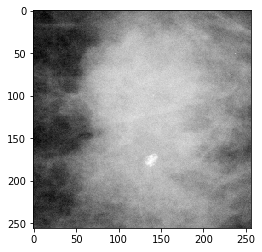

Label: [1. 0.]


In [10]:
idx = 2

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

In [11]:
def create_vgg16(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(1024, activation='relu'))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(output, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [12]:
vgg16_mass_benign_or_malignant_best = create_vgg16(dropout=0.5, fc_size=128, output = 2)

In [13]:
vgg16_mass_benign_or_malignant_best.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 33,686,914
Non-trainable params: 14,714,688
___________________________________

### Adam

In [14]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [15]:
# Train
history_vgg16_mass_benign_or_malignant_best = vgg16_mass_benign_or_malignant_best.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 1.9211 - recall: 0.5078
Epoch 00001: val_loss improved from inf to 1.19008, saving model to ../model/vgg16_mass_benign_or_malignant_best.h5
5/5 [==============================] - 15s 3s/step - loss: 1.9342 - recall: 0.5109 - val_loss: 1.1901 - val_recall: 0.5000
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0882 - recall: 0.5957
Epoch 00002: val_loss improved from 1.19008 to 0.83927, saving model to ../model/vgg16_mass_benign_or_malignant_best.h5
5/5 [==============================] - 11s 2s/step - loss: 1.1382 - recall: 0.5781 - val_loss: 0.8393 - val_recall: 0.4964
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9460 - recall: 0.5273
Epoch 00003: val_loss improved from 0.83927 to 0.70215, saving model to ../mode

Epoch 28/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6523 - recall: 0.6289
Epoch 00028: val_loss did not improve from 0.63696
5/5 [==============================] - 10s 2s/step - loss: 0.6479 - recall: 0.6266 - val_loss: 0.6703 - val_recall: 0.6439
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6377 - recall: 0.6356
Epoch 00029: val_loss did not improve from 0.63696
5/5 [==============================] - 10s 2s/step - loss: 0.6430 - recall: 0.6200 - val_loss: 0.7243 - val_recall: 0.5719
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6268 - recall: 0.6680
Epoch 00030: val_loss did not improve from 0.63696
5/5 [==============================] - 10s 2s/step - loss: 0.6407 - recall: 0.6547 - val_loss: 0.7893 - val_recall: 0.5647
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6554 - recall: 0.6165
Epoch 00031: val_loss did not improve from 0.63696
5/5 [==============================] - 11s 2s/step - loss: 

In [16]:
models.save_model(vgg16_mass_benign_or_malignant_best, '../model/vgg16_mass_benign_or_malignant_end.h5')

In [17]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best.history['val_recall']

In [18]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

In [19]:
print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 55
Epoch [opt]: 25
Valid accuracy [end]: 0.6079
Valid accuracy [opt]: 0.6115
Test accuracy [end]:  0.6601
Test accuracy [opt]:  0.6209
Valid loss [end]: 0.6718
Valid loss [opt]: 0.6370
Test loss [end]:  0.6415
Test loss [opt]:  0.6547


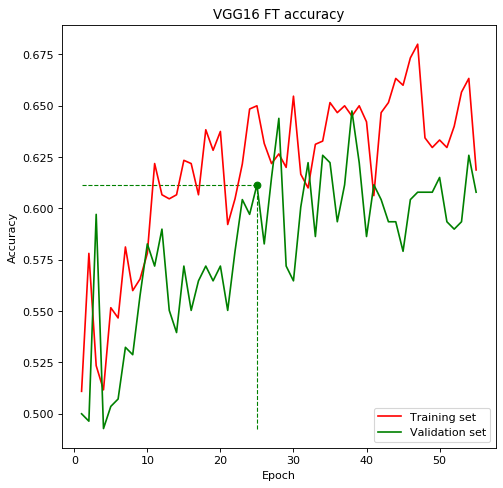

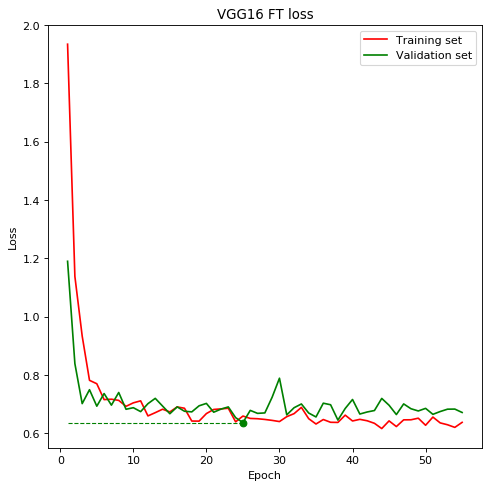

In [20]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [21]:
vgg16_mass_benign_or_malignant_best_SGD = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [22]:
# Train
history_vgg16_mass_benign_or_malignant_best_SGD = vgg16_mass_benign_or_malignant_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3132 - recall: 0.4703
Epoch 00001: val_loss improved from inf to 0.99218, saving model to ../model/vgg16_mass_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 10s 2s/step - loss: 1.2610 - recall: 0.4800 - val_loss: 0.9922 - val_recall: 0.5288
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2818 - recall: 0.4863
Epoch 00002: val_loss improved from 0.99218 to 0.86590, saving model to ../model/vgg16_mass_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 10s 2s/step - loss: 1.2528 - recall: 0.4859 - val_loss: 0.8659 - val_recall: 0.5647
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1702 - recall: 0.5085
Epoch 00003: val_loss did not improve from 0.86590
5/5 [==============================] - 11s 2s/step - loss: 1.1890 - recall: 0.5033 - val_loss: 0

Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9914 - recall: 0.5273
Epoch 00030: val_loss did not improve from 0.76837
5/5 [==============================] - 10s 2s/step - loss: 0.9832 - recall: 0.5312 - val_loss: 0.8451 - val_recall: 0.5468
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0292 - recall: 0.5645
Epoch 00031: val_loss did not improve from 0.76837
5/5 [==============================] - 10s 2s/step - loss: 1.0591 - recall: 0.5641 - val_loss: 0.8585 - val_recall: 0.5288
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1168 - recall: 0.5381
Epoch 00032: val_loss did not improve from 0.76837
5/5 [==============================] - 9s 2s/step - loss: 1.1021 - recall: 0.5583 - val_loss: 0.8318 - val_recall: 0.5396
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0547 - recall: 0.5156
Epoch 00033: val_loss did not improve from 0.76837
5/5 [==============================] - 10s 2s/step - loss: 1

In [23]:
models.save_model(vgg16_mass_benign_or_malignant_best_SGD, '../model/vgg16_mass_benign_or_malignant_end_SGD.h5')

In [24]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_SGD.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_SGD.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_SGD.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_SGD.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 71
Epoch [opt]: 41
Valid accuracy [end]: 0.5324
Valid accuracy [opt]: 0.6007
Test accuracy [end]:  0.5425
Test accuracy [opt]:  0.5490
Valid loss [end]: 0.8495
Valid loss [opt]: 0.6822
Test loss [end]:  0.8313
Test loss [opt]:  0.9018


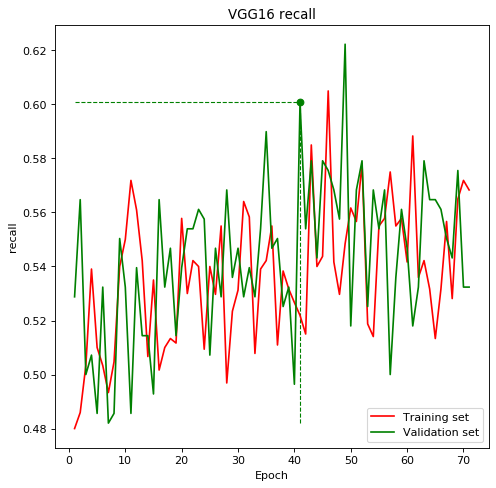

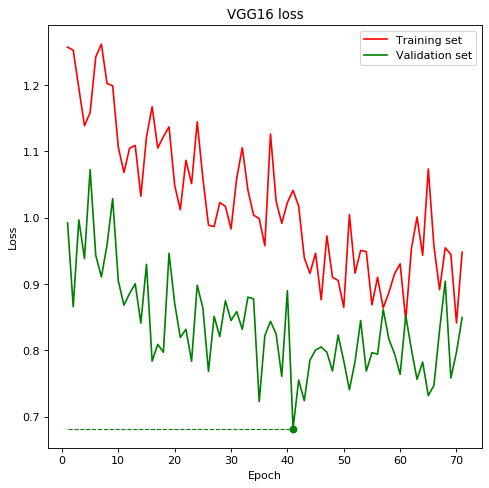

In [25]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [26]:
vgg16_mass_benign_or_malignant_best_RMSprop = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [27]:
# Train
history_vgg16_mass_benign_or_malignant_best_RMSprop = vgg16_mass_benign_or_malignant_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 4.7776 - recall: 0.4922
Epoch 00001: val_loss improved from inf to 0.72760, saving model to ../model/vgg16_mass_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 11s 2s/step - loss: 4.0737 - recall: 0.4828 - val_loss: 0.7276 - val_recall: 0.5576
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7845 - recall: 0.5293
Epoch 00002: val_loss improved from 0.72760 to 0.68500, saving model to ../model/vgg16_mass_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 11s 2s/step - loss: 0.7842 - recall: 0.5453 - val_loss: 0.6850 - val_recall: 0.5576
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7965 - recall: 0.5176
Epoch 00003: val_loss did not improve from 0.68500
5/5 [==============================] - 11s 2s/step - loss: 0.7977 - recall: 0.5172 - val

Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6507 - recall: 0.6289
Epoch 00030: val_loss did not improve from 0.65058
5/5 [==============================] - 10s 2s/step - loss: 0.6576 - recall: 0.6156 - val_loss: 0.6520 - val_recall: 0.6007
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6521 - recall: 0.5996
Epoch 00031: val_loss did not improve from 0.65058
5/5 [==============================] - 10s 2s/step - loss: 0.6665 - recall: 0.5859 - val_loss: 0.6790 - val_recall: 0.6511
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6396 - recall: 0.6543
Epoch 00032: val_loss did not improve from 0.65058
5/5 [==============================] - 10s 2s/step - loss: 0.6517 - recall: 0.6484 - val_loss: 0.6800 - val_recall: 0.6511
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6704 - recall: 0.6035
Epoch 00033: val_loss did not improve from 0.65058
5/5 [==============================] - 9s 2s/step - loss: 0

Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6409 - recall: 0.6445
Epoch 00061: val_loss did not improve from 0.63158
5/5 [==============================] - 11s 2s/step - loss: 0.6446 - recall: 0.6344 - val_loss: 0.6787 - val_recall: 0.6187
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6286 - recall: 0.6445
Epoch 00062: val_loss did not improve from 0.63158
5/5 [==============================] - 9s 2s/step - loss: 0.6186 - recall: 0.6617 - val_loss: 0.6560 - val_recall: 0.6763
Epoch 63/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6510 - recall: 0.6387
Epoch 00063: val_loss did not improve from 0.63158
5/5 [==============================] - 10s 2s/step - loss: 0.6406 - recall: 0.6422 - val_loss: 0.7157 - val_recall: 0.6331
Epoch 64/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6407 - recall: 0.6292
Epoch 00064: val_loss did not improve from 0.63158
5/5 [==============================] - 10s 2s/step - loss: 0

In [28]:
models.save_model(vgg16_mass_benign_or_malignant_best_RMSprop, '../model/vgg16_mass_benign_or_malignant_end_RMSprop.h5')

In [29]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_RMSprop.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_RMSprop.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_RMSprop.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_RMSprop.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 79
Epoch [opt]: 49
Valid accuracy [end]: 0.6223
Valid accuracy [opt]: 0.6367
Test accuracy [end]:  0.6307
Test accuracy [opt]:  0.6144
Valid loss [end]: 0.6868
Valid loss [opt]: 0.6316
Test loss [end]:  0.6543
Test loss [opt]:  0.6900


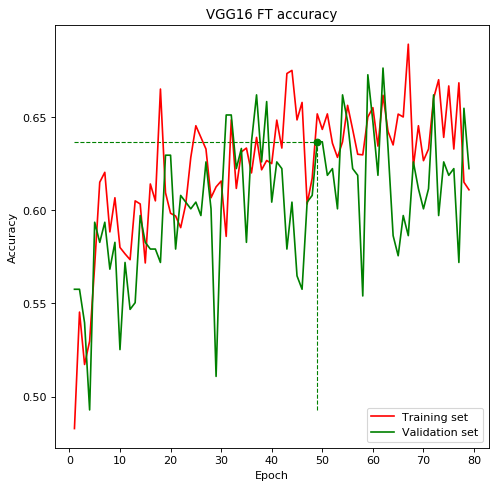

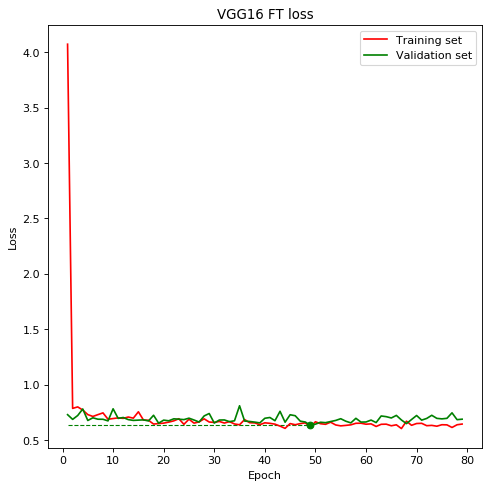

In [30]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [24]:
vgg16_mass_benign_or_malignant_best_Adadelta = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [25]:
# Train
history_vgg16_mass_benign_or_malignant_best_Adadelta = vgg16_mass_benign_or_malignant_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.5037 - recall: 0.4863
Epoch 00001: val_loss improved from inf to 1.21094, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5
5/5 [==============================] - 11s 2s/step - loss: 1.5400 - recall: 0.4950 - val_loss: 1.2109 - val_recall: 0.4928
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.5203 - recall: 0.4609
Epoch 00002: val_loss did not improve from 1.21094
5/5 [==============================] - 10s 2s/step - loss: 1.6136 - recall: 0.4563 - val_loss: 1.2142 - val_recall: 0.5144
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.5801 - recall: 0.4534
Epoch 00003: val_loss improved from 1.21094 to 1.03842, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5
5/5 [==============================] - 10s 2s/step - loss: 1.5931 - recall: 0.4567 - v

4/5 [=======================>......] - ETA: 1s - loss: 1.3478 - recall: 0.4785
Epoch 00029: val_loss improved from 0.90363 to 0.85541, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5
5/5 [==============================] - 11s 2s/step - loss: 1.3648 - recall: 0.4844 - val_loss: 0.8554 - val_recall: 0.5396
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2797 - recall: 0.4980
Epoch 00030: val_loss did not improve from 0.85541
5/5 [==============================] - 11s 2s/step - loss: 1.3133 - recall: 0.4883 - val_loss: 1.0561 - val_recall: 0.4748
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3150 - recall: 0.4414
Epoch 00031: val_loss did not improve from 0.85541
5/5 [==============================] - 11s 2s/step - loss: 1.2982 - recall: 0.4672 - val_loss: 0.9372 - val_recall: 0.5180
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2218 - recall: 0.5059
Epoch 00032: val_loss did not improve from 0.

In [26]:
models.save_model(vgg16_mass_benign_or_malignant_best_Adadelta, '../model/vgg16_mass_benign_or_malignant_end_Adadelta.h5')

In [27]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adadelta.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adadelta.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adadelta.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 83
Epoch [opt]: 53
Valid accuracy [end]: 0.5144
Valid accuracy [opt]: 0.5432
Test accuracy [end]:  0.5654
Test accuracy [opt]:  0.5621
Valid loss [end]: 1.0850
Valid loss [opt]: 0.8414
Test loss [end]:  0.8719
Test loss [opt]:  0.9040


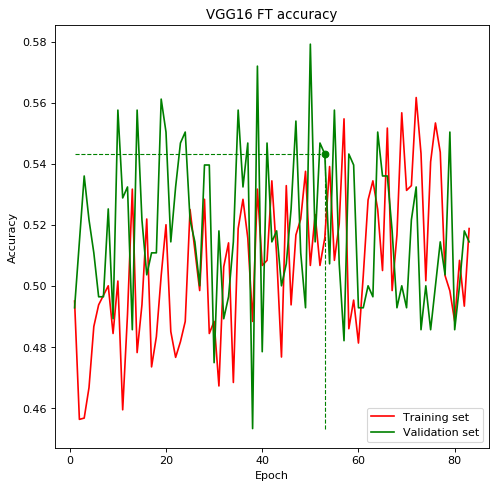

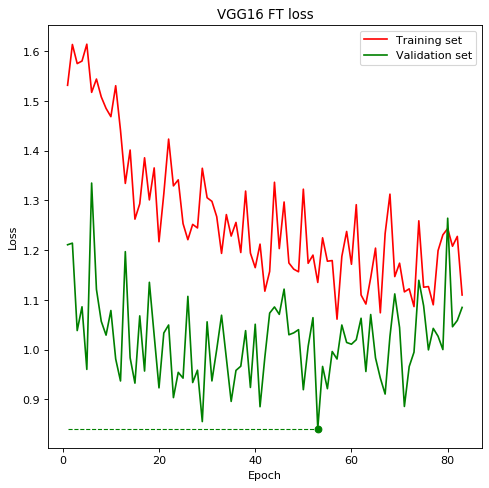

In [28]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [14]:
vgg16_mass_benign_or_malignant_best_Adagrad = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [15]:
# Train
history_vgg16_mass_benign_or_malignant_best_Adagrad = vgg16_mass_benign_or_malignant_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 1.3155 - recall: 0.5254
Epoch 00001: val_loss improved from inf to 1.07959, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 16s 3s/step - loss: 1.3194 - recall: 0.5167 - val_loss: 1.0796 - val_recall: 0.4604
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2858 - recall: 0.5098
Epoch 00002: val_loss improved from 1.07959 to 0.90174, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 10s 2s/step - loss: 1.3225 - recall: 0.5094 - val_loss: 0.9017 - val_recall: 0.5576
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2162 - recall: 0.5098
Epoch 00003: val_loss did not improve from 0.90174
5/5 [=======

Epoch 57/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8816 - recall: 0.5957
Epoch 00057: val_loss did not improve from 0.70178
5/5 [==============================] - 10s 2s/step - loss: 0.8884 - recall: 0.5781 - val_loss: 0.7284 - val_recall: 0.5827
Epoch 58/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8812 - recall: 0.5762
Epoch 00058: val_loss improved from 0.70178 to 0.68139, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 10s 2s/step - loss: 0.9235 - recall: 0.5625 - val_loss: 0.6814 - val_recall: 0.6007
Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8883 - recall: 0.5605
Epoch 00059: val_loss did not improve from 0.68139
5/5 [==============================] - 11s 2s/step - loss: 0.8432 - recall: 0.5667 - val_loss: 0.6868 - val_recall: 0.6115
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8403 - recall: 0.5684
Epoch 00060: val_loss did not imp

Epoch 87/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8646 - recall: 0.5684
Epoch 00087: val_loss did not improve from 0.67561
5/5 [==============================] - 10s 2s/step - loss: 0.8952 - recall: 0.5625 - val_loss: 0.7944 - val_recall: 0.5432
Epoch 88/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8293 - recall: 0.5938
Epoch 00088: val_loss did not improve from 0.67561
5/5 [==============================] - 10s 2s/step - loss: 0.8090 - recall: 0.5938 - val_loss: 0.7008 - val_recall: 0.5612
Epoch 89/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7609 - recall: 0.6144
Epoch 00089: val_loss did not improve from 0.67561
5/5 [==============================] - 10s 2s/step - loss: 0.7395 - recall: 0.6250 - val_loss: 0.6826 - val_recall: 0.6043
Epoch 90/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8818 - recall: 0.5352
Epoch 00090: val_loss did not improve from 0.67561
5/5 [==============================] - 10s 2s/step - loss: 

Epoch 117/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8067 - recall: 0.5805
Epoch 00117: val_loss did not improve from 0.66050
5/5 [==============================] - 10s 2s/step - loss: 0.8058 - recall: 0.5850 - val_loss: 0.7007 - val_recall: 0.5540
Epoch 118/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7739 - recall: 0.5820
Epoch 00118: val_loss did not improve from 0.66050
5/5 [==============================] - 10s 2s/step - loss: 0.7531 - recall: 0.5950 - val_loss: 0.7263 - val_recall: 0.5791
Epoch 119/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8647 - recall: 0.5720
Epoch 00119: val_loss did not improve from 0.66050
5/5 [==============================] - 10s 2s/step - loss: 0.8495 - recall: 0.5683 - val_loss: 0.7111 - val_recall: 0.5647
Epoch 120/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8000 - recall: 0.6074
Epoch 00120: val_loss did not improve from 0.66050
5/5 [==============================] - 10s 2s/step - lo

Epoch 148/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8048 - recall: 0.5723
Epoch 00148: val_loss improved from 0.65904 to 0.64342, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 11s 2s/step - loss: 0.8124 - recall: 0.5672 - val_loss: 0.6434 - val_recall: 0.6043
Epoch 149/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8213 - recall: 0.5169
Epoch 00149: val_loss did not improve from 0.64342
5/5 [==============================] - 10s 2s/step - loss: 0.8246 - recall: 0.5117 - val_loss: 0.7273 - val_recall: 0.5719
Epoch 150/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8377 - recall: 0.5898
Epoch 00150: val_loss did not improve from 0.64342
5/5 [==============================] - 10s 2s/step - loss: 0.8105 - recall: 0.5922 - val_loss: 0.6814 - val_recall: 0.5683
Epoch 151/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7674 - recall: 0.6211
Epoch 00151: val_loss did not

Epoch 00178: early stopping


In [16]:
models.save_model(vgg16_mass_benign_or_malignant_best_Adagrad, '../model/vgg16_mass_benign_or_malignant_end_Adagrad.h5')

In [17]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adagrad.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adagrad.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adagrad.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 178
Epoch [opt]: 148
Valid accuracy [end]: 0.5719
Valid accuracy [opt]: 0.6043
Test accuracy [end]:  0.5817
Test accuracy [opt]:  0.5752
Valid loss [end]: 0.6516
Valid loss [opt]: 0.6434
Test loss [end]:  0.7616
Test loss [opt]:  0.7763


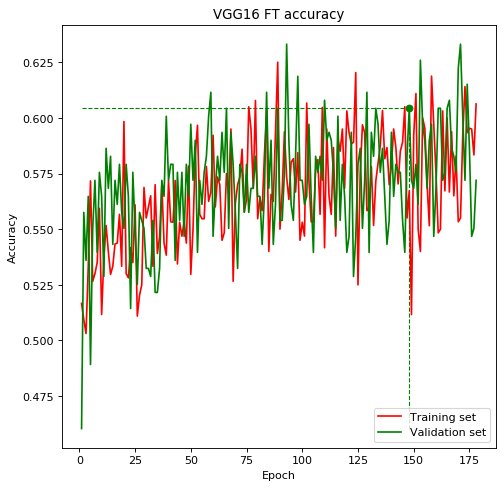

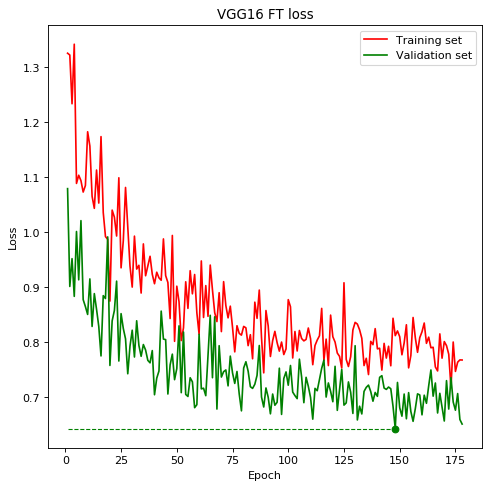

In [18]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [17]:
vgg16_mass_benign_or_malignant_best_Adamax = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [18]:
# Train
history_vgg16_mass_benign_or_malignant_best_Adamax = vgg16_mass_benign_or_malignant_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.9104 - recall: 0.5360
Epoch 00001: val_loss improved from inf to 1.05666, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 11s 2s/step - loss: 1.7566 - recall: 0.5400 - val_loss: 1.0567 - val_recall: 0.5108
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1597 - recall: 0.5312
Epoch 00002: val_loss improved from 1.05666 to 0.85489, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 12s 2s/step - loss: 1.1169 - recall: 0.5250 - val_loss: 0.8549 - val_recall: 0.5288
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0319 - recall: 0.4725
Epoch 00003: val_loss improved from 0.85489 to 0.68912, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adamax.h5
5/5 [=========

Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7087 - recall: 0.5996
Epoch 00030: val_loss did not improve from 0.63324
5/5 [==============================] - 10s 2s/step - loss: 0.6995 - recall: 0.5950 - val_loss: 0.6376 - val_recall: 0.5935
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6804 - recall: 0.5762
Epoch 00031: val_loss did not improve from 0.63324
5/5 [==============================] - 10s 2s/step - loss: 0.6789 - recall: 0.5891 - val_loss: 0.6445 - val_recall: 0.6223
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7107 - recall: 0.5657
Epoch 00032: val_loss did not improve from 0.63324
5/5 [==============================] - 10s 2s/step - loss: 0.7020 - recall: 0.5733 - val_loss: 0.6593 - val_recall: 0.5863
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6980 - recall: 0.5977
Epoch 00033: val_loss did not improve from 0.63324
5/5 [==============================] - 10s 2s/step - loss: 

In [19]:
models.save_model(vgg16_mass_benign_or_malignant_best_Adamax, '../model/vgg16_mass_benign_or_malignant_end_Adamax.h5')

In [20]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adamax.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adamax.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adamax.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_Adamax.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 51
Epoch [opt]: 21
Valid accuracy [end]: 0.5683
Valid accuracy [opt]: 0.5899
Test accuracy [end]:  0.5850
Test accuracy [opt]:  0.5686
Valid loss [end]: 0.6597
Valid loss [opt]: 0.6332
Test loss [end]:  0.6843
Test loss [opt]:  0.7140


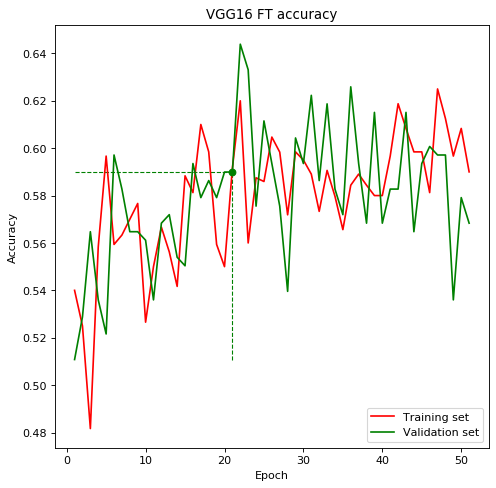

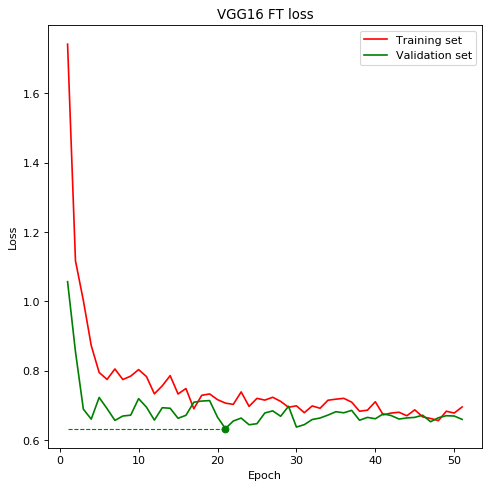

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [12]:
vgg16_mass_benign_or_malignant_best_Nadam = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [13]:
# Train
history_vgg16_mass_benign_or_malignant_best_Nadam = vgg16_mass_benign_or_malignant_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 2.2126 - recall: 0.5078
Epoch 00001: val_loss improved from inf to 1.20365, saving model to ../model/vgg16_mass_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 14s 3s/step - loss: 2.0004 - recall: 0.5141 - val_loss: 1.2036 - val_recall: 0.4928
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9504 - recall: 0.5527
Epoch 00002: val_loss improved from 1.20365 to 0.79560, saving model to ../model/vgg16_mass_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 11s 2s/step - loss: 1.0787 - recall: 0.5453 - val_loss: 0.7956 - val_recall: 0.5468
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8659 - recall: 0.5625
Epoch 00003: val_loss did not improve from 0.79560
5/5 [===========

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6437 - recall: 0.6348
Epoch 00029: val_loss did not improve from 0.60658
5/5 [==============================] - 10s 2s/step - loss: 0.6503 - recall: 0.6233 - val_loss: 0.6913 - val_recall: 0.6151
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6547 - recall: 0.6289
Epoch 00030: val_loss did not improve from 0.60658
5/5 [==============================] - 11s 2s/step - loss: 0.6632 - recall: 0.6234 - val_loss: 0.6783 - val_recall: 0.6151
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6458 - recall: 0.6271
Epoch 00031: val_loss did not improve from 0.60658
5/5 [==============================] - 11s 2s/step - loss: 0.6512 - recall: 0.6200 - val_loss: 0.6754 - val_recall: 0.6043
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6825 - recall: 0.6191
Epoch 00032: val_loss did not improve from 0.60658
5/5 [==============================] - 10s 2s/step - loss: 

In [14]:
models.save_model(vgg16_mass_benign_or_malignant_best_Nadam, '../model/vgg16_mass_benign_or_malignant_end_Nadam.h5')

In [15]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_Nadam.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_Nadam.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_Nadam.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_Nadam.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 42
Epoch [opt]: 12
Valid accuracy [end]: 0.6295
Valid accuracy [opt]: 0.6367
Test accuracy [end]:  0.6373
Test accuracy [opt]:  0.6078
Valid loss [end]: 0.6285
Valid loss [opt]: 0.6066
Test loss [end]:  0.6345
Test loss [opt]:  0.7594


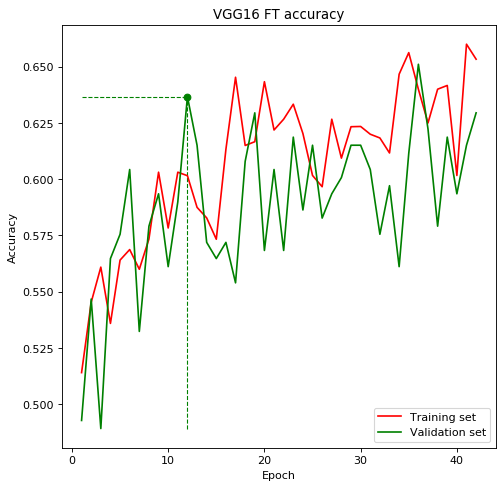

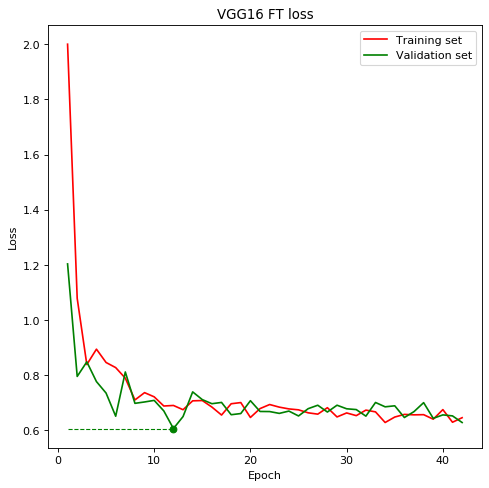

In [16]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Ftrl

In [17]:
vgg16_mass_benign_or_malignant_best_Ftrl = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_Ftrl.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_Ftrl.compile(optimizer=optimizers.Ftrl(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [18]:
# Train
history_vgg16_mass_benign_or_malignant_best_Ftrl = vgg16_mass_benign_or_malignant_best_Ftrl.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9339 - recall: 0.4629
Epoch 00001: val_loss improved from inf to 0.69193, saving model to ../model/vgg16_mass_benign_or_malignant_best_Ftrl.h5
5/5 [==============================] - 11s 2s/step - loss: 0.8857 - recall: 0.4734 - val_loss: 0.6919 - val_recall: 0.4964
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6937 - recall: 0.4513
Epoch 00002: val_loss did not improve from 0.69193
5/5 [==============================] - 10s 2s/step - loss: 0.6937 - recall: 0.4483 - val_loss: 0.6919 - val_recall: 0.4964
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6937 - recall: 0.4531
Epoch 00003: val_loss did not improve from 0.69193
5/5 [==============================] - 10s 2s/step - loss: 0.6937 - recall: 0.4550 - val_loss: 0.6920 - val_recall: 0.4964
Epoch 4/300
4/5 [=======================>....

Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6927 - recall: 0.5678
Epoch 00031: val_loss did not improve from 0.69193
5/5 [==============================] - 10s 2s/step - loss: 0.6927 - recall: 0.5700 - val_loss: 0.6928 - val_recall: 0.5647
Epoch 00031: early stopping


In [19]:
models.save_model(vgg16_mass_benign_or_malignant_best_Ftrl, '../model/vgg16_mass_benign_or_malignant_end_Ftrl.h5')

In [20]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_Ftrl.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_Ftrl.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_Ftrl.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_Ftrl.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_Ftrl.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_Ftrl.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 31
Epoch [opt]: 1
Valid accuracy [end]: 0.5647
Valid accuracy [opt]: 0.4964
Test accuracy [end]:  0.5621
Test accuracy [opt]:  0.4314
Valid loss [end]: 0.6928
Valid loss [opt]: 0.6919
Test loss [end]:  0.6926
Test loss [opt]:  0.6939


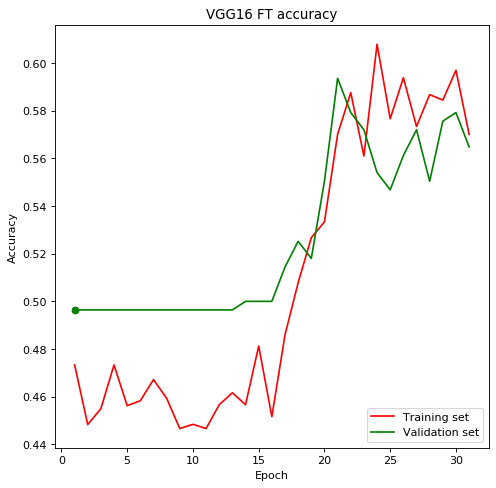

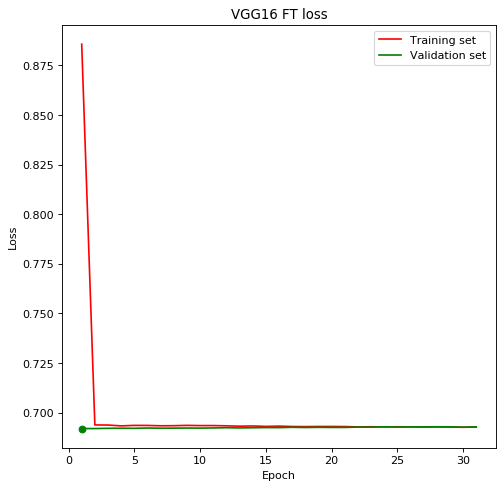

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [11]:
vgg16_mass_benign_or_malignant_1 = models.load_model('../model/vgg16_mass_benign_or_malignant_best.h5')

for layer in vgg16_mass_benign_or_malignant_1.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_mass_benign_or_malignant_1.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg16_mass_benign_or_malignant_1.summary()
vgg16_mass_benign_or_malignant_1.get_layer('vgg16').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 36,046,722
Non-trainable params: 12,354,880
___________________________________

In [12]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg16_mass_benign_or_malignant_1_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [13]:
history_fit = vgg16_mass_benign_or_malignant_1.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 0.6797 - recall: 0.6241
Epoch 00001: val_loss improved from inf to 0.60657, saving model to ../model/vgg16_mass_begign_or_malignant_1_best.h5
5/5 [==============================] - 15s 3s/step - loss: 0.6866 - recall: 0.6298 - val_loss: 0.6066 - val_recall: 0.5970
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6093 - recall: 0.6660
Epoch 00002: val_loss improved from 0.60657 to 0.53692, saving model to ../model/vgg16_mass_begign_or_malignant_1_best.h5
5/5 [==============================] - 11s 2s/step - loss: 0.6063 - recall: 0.6687 - val_loss: 0.5369 - val_recall: 0.6464
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6207 - recall: 0.6120
Epoch 00003: val_loss did not improve from 0.53692
5/5 [===================

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5519 - recall: 0.7084
Epoch 00029: val_loss did not improve from 0.50520
5/5 [==============================] - 10s 2s/step - loss: 0.5751 - recall: 0.6943 - val_loss: 0.5253 - val_recall: 0.6388
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5744 - recall: 0.7148
Epoch 00030: val_loss did not improve from 0.50520
5/5 [==============================] - 10s 2s/step - loss: 0.5900 - recall: 0.7063 - val_loss: 0.5422 - val_recall: 0.6730
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5350 - recall: 0.7363
Epoch 00031: val_loss did not improve from 0.50520
5/5 [==============================] - 11s 2s/step - loss: 0.5396 - recall: 0.7250 - val_loss: 0.5717 - val_recall: 0.6578
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5785 - recall: 0.6953
Epoch 00032: val_loss did not improve from 0.50520
5/5 [==============================] - 11s 2s/step - loss: 

In [18]:
models.save_model(vgg16_mass_benign_or_malignant_1, '../model/vgg16_mass_benign_or_malignant_1_end.h5')

In [20]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_mass_benign_or_malignant_1 = models.load_model('../model/vgg16_mass_benign_or_malignant_1_best.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_1.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant_1.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 53
Epoch [opt]: 23
Valid accuracy [end]: 0.6882
Valid accuracy [opt]: 0.6730
Test accuracy [end]:  0.5317
Test accuracy [opt]:  0.4974
Valid loss [end]: 0.6423
Valid loss [opt]: 0.5052
Test loss [end]:  1.0179
Test loss [opt]:  0.9418


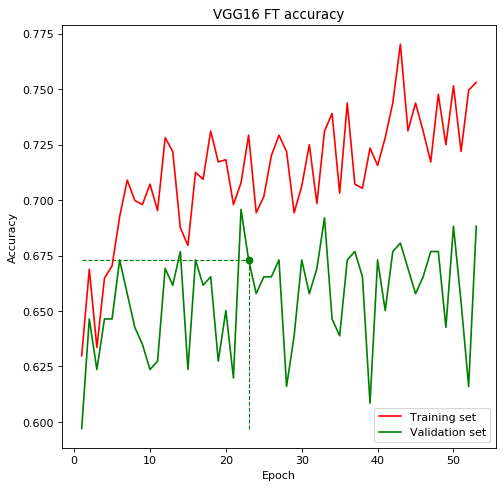

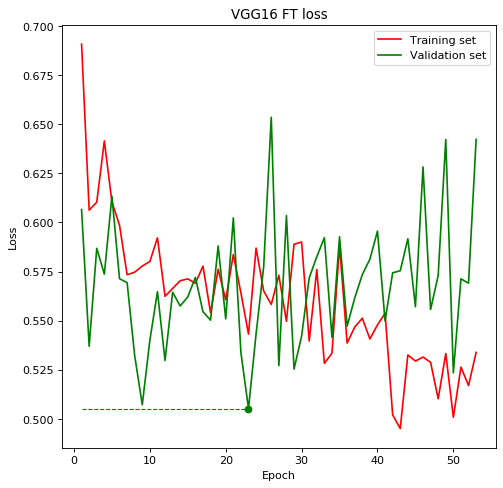

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();